In [1]:
# import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import optuna

from torch.utils.data import DataLoader
from src.data import MovingMnistDataset
import torch.optim as optim
import time

from src.dl_models.unet import UNet
from src import model, visualization, evaluate, data, preprocessing,train

In [ ]:
# Generate small random validation set
import random
import pandas as pd

n_elements = 5
# chose secuence
id_secuences = random.sample(range(0, 3000), n_elements)
id_secuences.sort()
print(id_secuences)

#load data
path = 'data/moving_mnist/moving_mnist_val/'
csv = 'data/moving_mnist/moving_mnist_val.csv'
df = pd.read_csv(csv, header=None)
# print(df)

df_copy = df.iloc[id_secuences]
df_copy.to_csv('data/moving_mnist/moving_mnist_val_5seq.csv', header=None, index=False)  

In [2]:
# Optuna
class Objective_optuna(object):
    def __init__(self, path, csv, path_val, csv_val, device):
        # Called when the study is created
        self.device = device
        self.path = path
        self.csv = csv
        self.path_val = path_val
        self.csv_val = csv_val
        
    def __call__(self, trial):
        # Called on each trial
        # Hyperparameters
        n_channels=3
        n_classes=1

        # Load data
        mnist_dataset = MovingMnistDataset(path=self.path, csv=self.csv, shuffle=True)
        loader = DataLoader(mnist_dataset, batch_size=10)
        mnist_dataset_val = MovingMnistDataset(path=self.path_val, csv=self.csv_val, shuffle=False)
        loader_val = DataLoader(mnist_dataset_val, batch_size=10)

        # Initialize network
        model = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=True).to(device)
        model.train()

        # Hyperparameters
        # lr = 0.001
        # optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = trial.suggest_float("lr", 1e-5, 1e-1)
        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

        # criterion_name =  trial.suggest_categorical("criterion", ["MSELoss", "L1Loss"])
        # criterion = getattr(nn, criterion_name)()
        criterion = nn.MSELoss()

        loss_history, loss_history_val = train.train_model(
            model,
            loader,
            criterion,
            optimizer,
            self.device,
            curr_epoch=0,
            loss_history=[],
            train_for=10,
            verbose=True,
            checkpoint_every=10,
            print_cuda_mem=False,
            loader_val=loader_val,
            trial=trial
        )
        return loss_history_val[-1]

path = 'data/moving_mnist/moving_mnist_train/'
csv = 'data/moving_mnist/moving_mnist_train_3000.csv'
path_val = 'data/moving_mnist/moving_mnist_val/'
csv_val = 'data/moving_mnist/moving_mnist_val_5seq.csv'

# Set device
USE_CUDA = True
device = torch.device('cuda' if torch.cuda.is_available()
                    and USE_CUDA else 'cpu')
print(f'Using {device}')

# Execute an optimization by using an `Objective` instance.
study = optuna.create_study(sampler=optuna.samplers.TPESampler()) #default sampler
study.optimize(Objective_optuna(path, csv, path_val, csv_val, device), n_trials=1)

print("\nBest trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-05-27 20:07:13,318] A new study created in memory with name: no-name-fa6e0f97-58a5-403f-b77a-28cf913e7cb1
Using cuda
EPOCH: 1 Time elapsed: 240.08 secs.
EPOCH: 2 Time elapsed: 226.62 secs.
EPOCH: 3 Time elapsed: 229.05 secs.
EPOCH: 4 Time elapsed: 227.21 secs.
EPOCH: 5 Time elapsed: 226.96 secs.
EPOCH: 6 Time elapsed: 229.20 secs.
EPOCH: 7 Time elapsed: 227.02 secs.
EPOCH: 8 Time elapsed: 226.84 secs.
EPOCH: 9 Time elapsed: 226.83 secs.
EPOCH: 10 Time elapsed: 226.86 secs.
[I 2021-05-27 20:45:22,473] Trial 0 finished with value: 0.01699612214643922 and parameters: {}. Best is trial 0 with value: 0.01699612214643922.

Best trial:
  Value:  0.01699612214643922
  Params: 


Using cuda


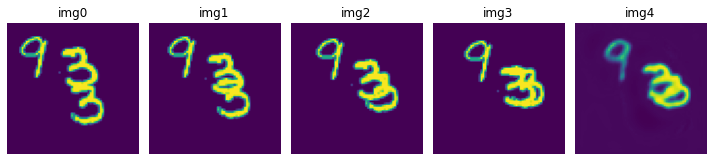

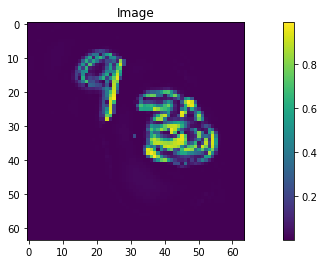

error_average 0.014405526100285808


In [2]:
# Test Model

# Set device
USE_CUDA = True
device = torch.device('cuda' if torch.cuda.is_available()
                    and USE_CUDA else 'cpu')
print(f'Using {device}')

path_test = 'data/moving_mnist/moving_mnist_test/'
csv_test = 'data/moving_mnist/moving_mnist_test.csv'
load_path = 'checkpoints/model_epoch10.pt'

n_channels=3
n_classes=1

model_test = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=True).to(device)
model_test.load_state_dict(torch.load(load_path)["model_state_dict"])
model_test.eval()

mnist_dataset_test = MovingMnistDataset(path=path_test, csv=csv_test, shuffle=True)
loader_test = DataLoader(mnist_dataset_test, batch_size=10)

# Test one sample
(curr_seq, idxs, inputs, targets) = iter(loader_test).next()

with torch.no_grad():
  prueba = model_test(inputs.to(device=device, dtype=torch.float32)).cpu()

L = [inputs[0][0], inputs[0][1], inputs[0][2], targets[0][0], prueba[0][0]]
visualization.show_image_list(L, 1)
visualization.show_images_diff(targets[0][0], prueba[0][0])

# Test model
criterion = nn.MSELoss()
error_average = evaluate.test_model(model_test, loader_test, criterion, device)
print("error_average", error_average)

In [3]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [8]:
optuna.visualization.plot_optimization_history(study)

In [4]:
plot_intermediate_values(study)